# Beyond the Known: Looking for Unexpected Patterns in Lab Markers Across a Sample Population

---

**Author:** Uzoma Stephen Uzoma, MD  
**Date:** Dec 31, 2025  

--- 

## Background
Cardiometabolic risk is influenced by interactions between demographic factors, body composition, blood pressure, lifestyle behaviors, and biochemical markers. Population-level datasets allow these relationships to be explored at scale and compared with established clinical and biological knowledge.

The National Health and Nutrition Examination Survey (NHANES) is a nationally representative, cross-sectional survey that combines interview data, physical examinations, supplement use, and laboratory measurements. This makes it well suited for exploratory analyses of cardiometabolic health in the general population.

Anthropometric measures such as body mass index, waist circumference, and waist-to-hip ratio capture different aspects of adiposity, with central fat measures often showing stronger associations with metabolic dysfunction. Laboratory markers including glucose, insulin, lipid fractions, inflammatory markers, and micronutrient levels provide insight into metabolic and cardiometabolic status.

---

# Aim  
This analysis explores associations between demographics, anthropometry, blood pressure, supplement use, and cardiometabolic laboratory markers in NHANES, focusing on effect sizes and biologically plausible patterns rather than causal inference.

---

## Reproducibility Note

Data cleaning and assembly were completed in a separate notebook.  
This notebook focuses entirely on analysis, visuals, and interpretation.


## Table of Contents
1. [Load Dataset](#load-dataset-and-variables)
2. [Who Is in This Dataset?](#who-is-in-this-dataset?)
3. [Demographics vs Labs](#objective-2-demographics-vs-labs)
4. [Supplements vs Labs](#objective-3-supplements-vs-labs)
5. [Anthropometry vs Labs](#objective-4-anthropometry-vs-labs)
6. [Blood Pressure vs Labs](#objective-5-blood-pressure-vs-labs)
7. [Correlation Among Labs](#labs-vs-labs)
8. [Conclusions & Insights](#conclusion)


## Load Dataset and Variables

In [6]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import spearmanr, kruskal

In [7]:
# Load prepared dataset
file = '../data/nhanes_final_dataset.csv'
df = pd.read_csv(file)

In [8]:
# Display the first few rows of the dataframe
df.head()

,SEQN,gender,age,race,marital_status,education,years_in_us,is_pregnant,poverty_index,takes_cholesterol_supplement,...,uacr_mg_per_g,hdl_cholesterol_mg_per_dL,triglycerides_mg_per_dL,ldl_cholesterol_martin_hopkins_mg_per_dL,total_cholesterol_mg_per_dL,fasting_glucose_mg_per_dL,insulin_uU_per_mL,hs_crp_mg_per_L,ferritin_ng_per_mL,vitamin_d2_d3_nmol_per_L
0,130378.0,1.0,43.0,6.0,1.0,5.0,6.0,NaN,5.00,NaN,...,17.00,45.0,153.0,190.0,264.0,113.0,15.53,1.78,NaN,58.9
1,130379.0,1.0,66.0,3.0,1.0,5.0,NaN,NaN,5.00,NaN,...,6.64,60.0,86.0,135.0,214.0,99.0,19.91,2.03,NaN,60.5
2,130380.0,2.0,44.0,2.0,1.0,3.0,6.0,2.0,1.41,0.0,...,7.92,49.0,375.0,90.0,187.0,156.0,16.33,5.62,13.3,39.4
3,130381.0,2.0,5.0,7.0,NaN,NaN,NaN,NaN,1.53,0.0,...,7.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN,3.60,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Create more columns

# Decode Relevant Demographic Variables
df['gender_label'] = df['gender'].map({1: 'Male', 2: 'Female'})
df['race_label'] = df['race'].map({1: 'Mexican American', 2: 'Other Hispanic', 3: 'Non-Hispanic White',
                                   4: 'Non-Hispanic Black', 6: 'Non-Hispanic Asian', 
                                   7: 'Other Race (including multiracial)'})
df['education_label'] = df['education'].map({1: '< 9th grade', 2: '9-11th grade (and 12th grade with no diploma)', 
                                             3: 'high school graduate', 4: 'AA degree or some college', 
                                             5: 'College graduate or above', 7: np.nan, 9: np.nan})

# Waist to Hip ratio
df['waist_hip_ratio'] = df['waist_circumference_cm'] / df['hip_circumference_cm']


# BP Categories
df['bp_category_systolic'] = pd.cut(df['avg_systolic_bp'], 
                           bins=[0, 120, 130, 140, 180, np.inf],
                           labels=['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis'])
df['bp_category_diastolic'] = pd.cut(df['avg_diastolic_bp'], 
                           bins=[0, 80, 90, 120, np.inf],
                           labels=['Normal', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis'])
def determine_bp_category(row):
    systolic_cat = row['bp_category_systolic']
    diastolic_cat = row['bp_category_diastolic']
    categories = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis']
    for category in reversed(categories):
        if systolic_cat == category or diastolic_cat == category:
            return category
    return np.nan    

df['bp_category'] = df.apply(determine_bp_category, axis=1)


# Supplement burden score grouping
df['supplement_burden_score_group'] = pd.cut(df['supplement_burden_score'], bins=[-1, 0, 2, 4, np.inf],
                                            labels=['0', '1-2', '3-4', '5+'], right=True) 

# Move the derived group to just after its parent
suppl_grp = df.pop('supplement_burden_score_group')
df.insert(df.columns.get_loc('supplement_burden_score')+1, 'supplement_burden_score_group', suppl_grp)

In [10]:
# Define global variables

# Demographics
demo_cont = {'age': 'Age', 'poverty_index': 'Poverty Index'}
demo_cat = {'gender_label': 'Gender', 'race_label': 'Race', 'education_label': 'Education Level'}

# BP
bp_order = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis']

# Labs
labs = {'uacr_mg_per_g': 'Urine Albumin Creatinine Ratio',
               'hdl_cholesterol_mg_per_dL': 'HDL Cholesterol',
               'triglycerides_mg_per_dL': 'Triglycerides',
               'ldl_cholesterol_martin_hopkins_mg_per_dL': 'LDL Cholesterol',
               'total_cholesterol_mg_per_dL': 'Total Cholesterol',
               'fasting_glucose_mg_per_dL': 'Fasting Plasma Glucose',
               'insulin_uU_per_mL': 'Insulin',
               'hs_crp_mg_per_L': 'C-Reactive Protein',
               'ferritin_ng_per_mL': 'Ferritin',
               'vitamin_d2_d3_nmol_per_L': 'Vitamin D'}

# Supplements
# Supplement columns
supplement_cols = [col for col in df.columns if col.startswith('takes_')]

# Clean supplement labels
supplement_labels = [
    col.replace('takes_', '').replace('_', ' ').replace('supplement', '').title()
    for col in supplement_cols
]

# Parameters
effect_cutoff_cont = 0.3   # for Spearman
effect_cutoff_cat = 0.06   # epsilon-squared threshold for Kruskal-Wallis


## Objective 1: Who Is in This Dataset?

Before looking for patterns, it helps to understand the people behind the numbers.

### What I looked at
I explored basic characteristics like age, sex, race, poverty index, BMI, WHR, and BP.

### Visuals
- Distributions of relevant demographics  
- Relationships between demographics, anthropometry, and BP

### Why it matters
This sets the stage. It shows whether the dataset leans younger or older, leaner or heavier, how body fat is distributed overall, etc.

C:\Users\UZOMA\AppData\Local\Temp\ipykernel_11800\4128907938.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(labels, rotation=20)
C:\Users\UZOMA\AppData\Local\Temp\ipykernel_11800\4128907938.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


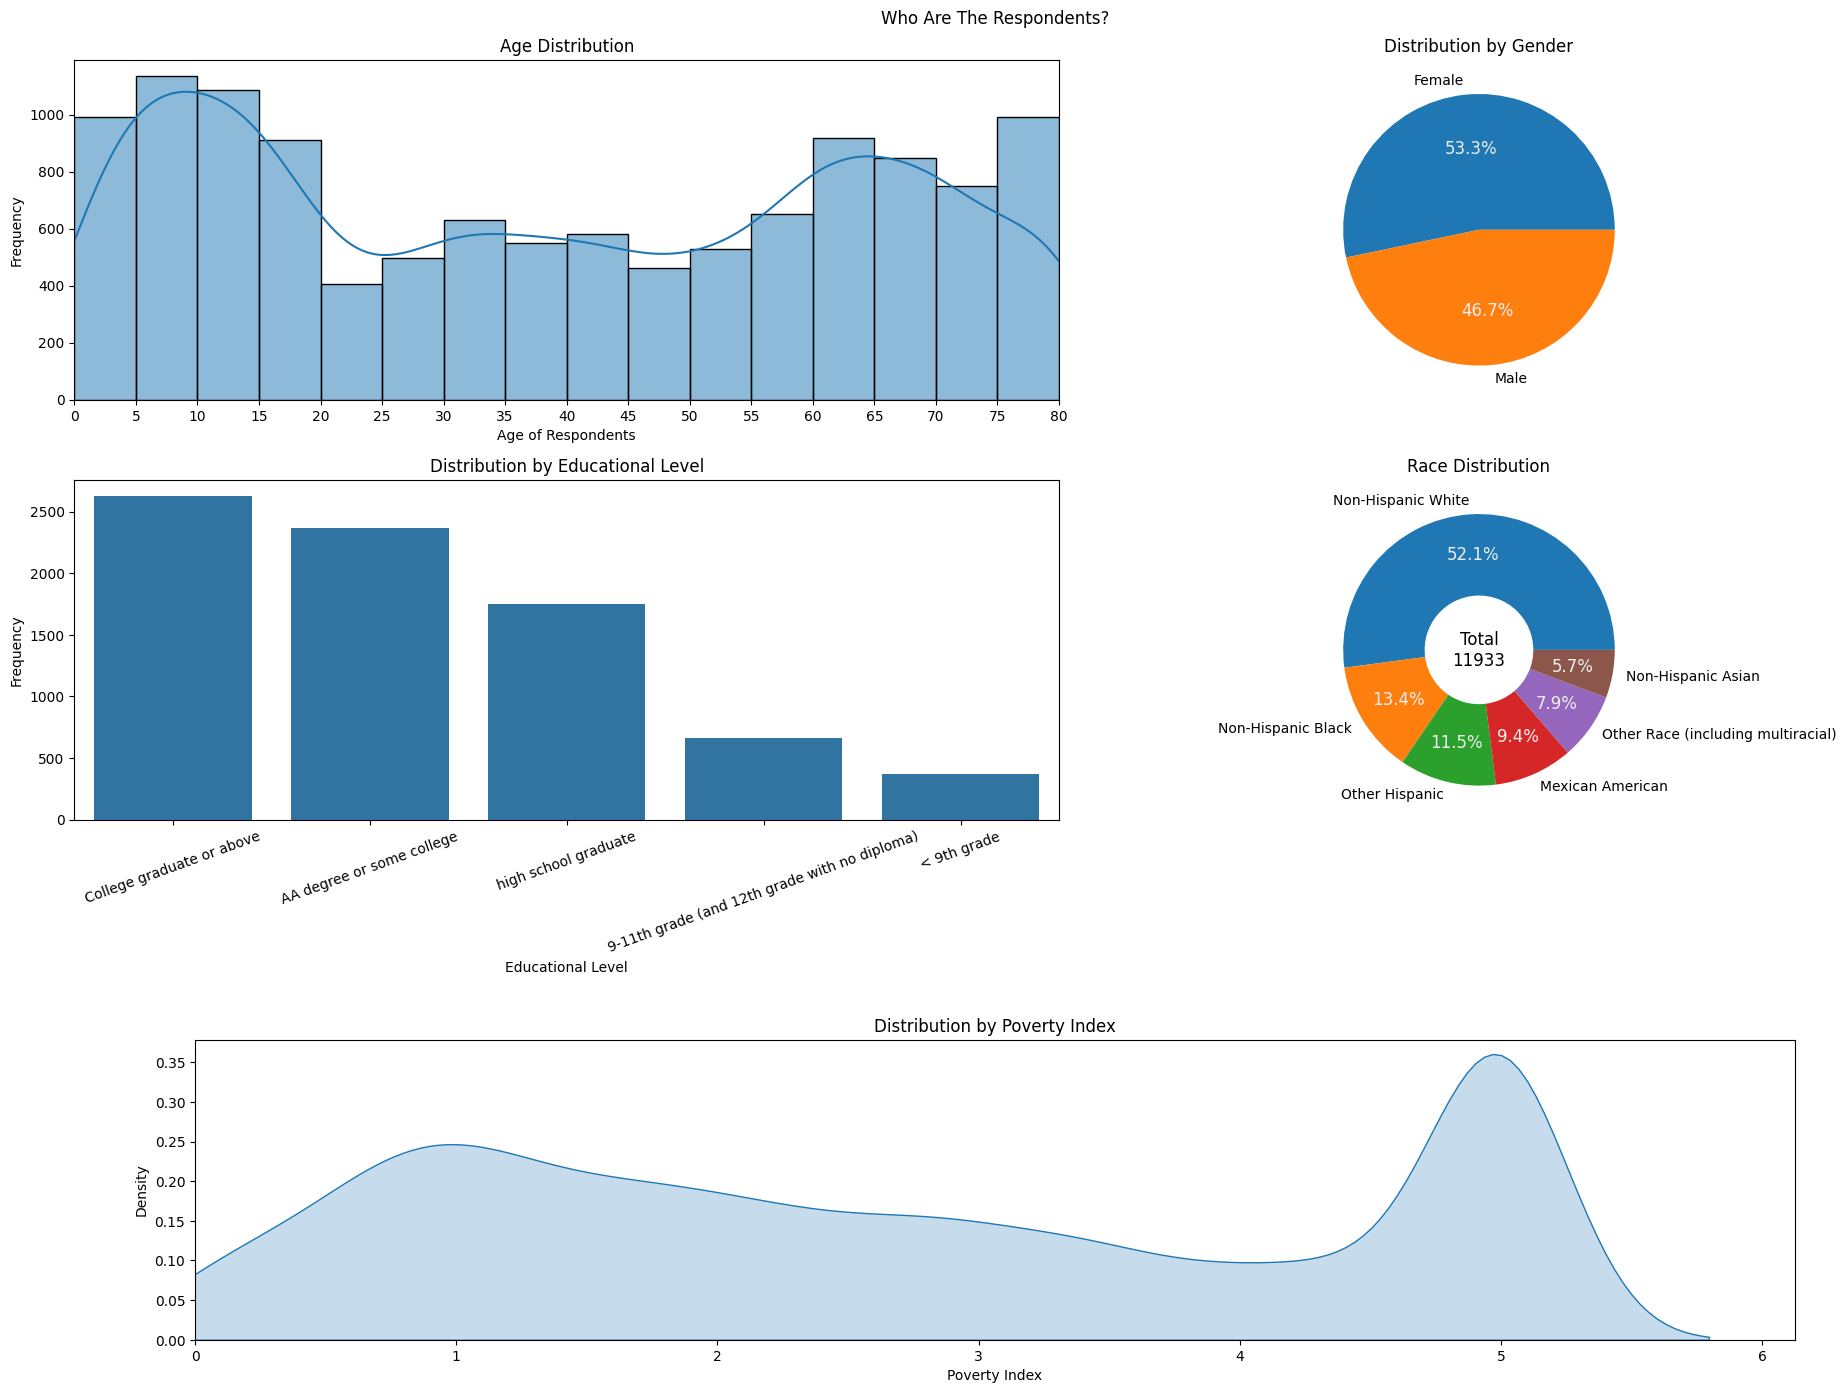

In [11]:
# Show demographic distribution
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

# age
bin_width = 5
age_data = df.dropna(subset='age')
sns.histplot(data=age_data, x='age', 
             binwidth=bin_width, kde=True, ax=axs[0]) 
axs[0].set_xticks(range(0, int(df['age'].max()) + 1, bin_width))
axs[0].set_xlim(0, df['age'].max())
axs[0].set_xlabel('Age of Respondents')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Age Distribution')

# sex
gender_counts = df.dropna(subset='gender_label')['gender_label'].value_counts()
_, _, autotexts = axs[1].pie(gender_counts, autopct='%1.1f%%', labels=gender_counts.index) 
for autotext in autotexts:
    autotext.set_color('#eeeeee')
    autotext.set_fontsize(12)
axs[1].set_title('Distribution by Gender')

# education
education_data = df.dropna(subset='education_label')
labels= education_data['education_label'].value_counts().index
sns.countplot(data=education_data, x='education_label', 
              order=labels, ax=axs[2])
axs[2].set_xlabel('Educational Level')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution by Educational Level')
axs[2].set_xticklabels(labels, rotation=20)

# race
race_counts = df.dropna(subset='race_label')['race_label'].value_counts()
_, _, autotexts = axs[3].pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', 
                             pctdistance=0.7, wedgeprops={'width':0.6})
for autotext in autotexts:
    autotext.set_color('#eeeeee')
    autotext.set_fontsize(12)
axs[3].text(0, 0, f'Total\n{race_counts.sum()}', ha='center', va='center', fontsize=12)
axs[3].set_title('Race Distribution')

# poverty index
poverty_index_data = df.dropna(subset='poverty_index')
ax5 = fig.add_axes([0.1, -0.35, 0.8, 0.3])
sns.kdeplot(data=poverty_index_data, x='poverty_index', fill=True, ax=ax5)
ax5.set_xlim(0,)
ax5.set_xlabel('Poverty Index')
ax5.set_ylabel('Density')
ax5.set_title('Distribution by Poverty Index')


plt.suptitle('Who Are The Respondents?')
plt.tight_layout()
plt.show()

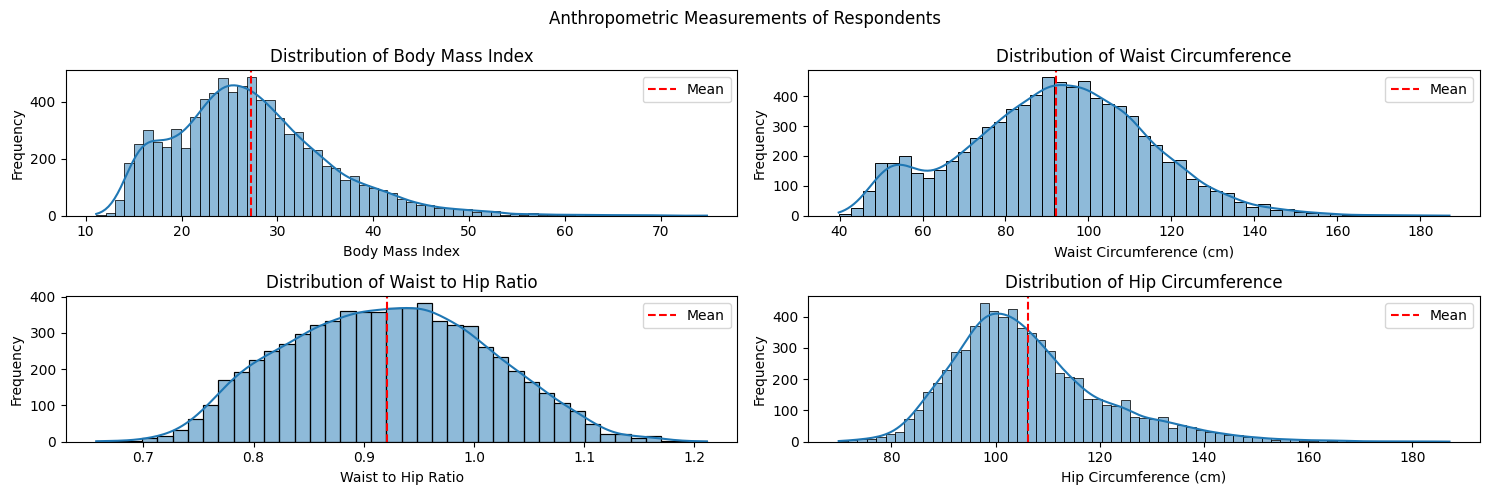

In [12]:
# Show distribution of anthropometry
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
axs = axs.flatten()

# BMI
bmi_data = df.dropna(subset='bmi')
sns.histplot(data=bmi_data, x='bmi', kde=True, ax=axs[0])
axs[0].set_xlabel('Body Mass Index')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Body Mass Index')
axs[0].axvline(bmi_data['bmi'].mean(), color='red', linestyle='--', label='Mean')
axs[0].legend()

# Waist Circumference
wc_data = df.dropna(subset='waist_circumference_cm')
sns.histplot(data=wc_data, x='waist_circumference_cm', kde=True, ax=axs[1])
axs[1].set_xlabel('Waist Circumference (cm)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Waist Circumference')
axs[1].axvline(wc_data['waist_circumference_cm'].mean(), color='red', linestyle='--', label='Mean')
axs[1].legend()

# Waist to Hip Ratio
whr_data = df.dropna(subset=['waist_hip_ratio'])
sns.histplot(data=whr_data, x='waist_hip_ratio', kde=True, ax=axs[2])
axs[2].set_xlabel('Waist to Hip Ratio')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Waist to Hip Ratio')
axs[2].axvline(whr_data['waist_hip_ratio'].mean(), color='red', linestyle='--', label='Mean')
axs[2].legend()

# Hip Circumference
hip_data = df.dropna(subset='hip_circumference_cm')
sns.histplot(data=hip_data, x='hip_circumference_cm', kde=True, ax=axs[3])
axs[3].set_xlabel('Hip Circumference (cm)')
axs[3].set_ylabel('Frequency')
axs[3].set_title('Distribution of Hip Circumference')
axs[3].axvline(hip_data['hip_circumference_cm'].mean(), color='red', linestyle='--', label='Mean')
axs[3].legend()

plt.suptitle('Anthropometric Measurements of Respondents')
plt.tight_layout()

C:\Users\UZOMA\AppData\Local\Temp\ipykernel_11800\2966293220.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(bp_category_counts.index, rotation=20)
C:\Users\UZOMA\AppData\Local\Temp\ipykernel_11800\2966293220.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


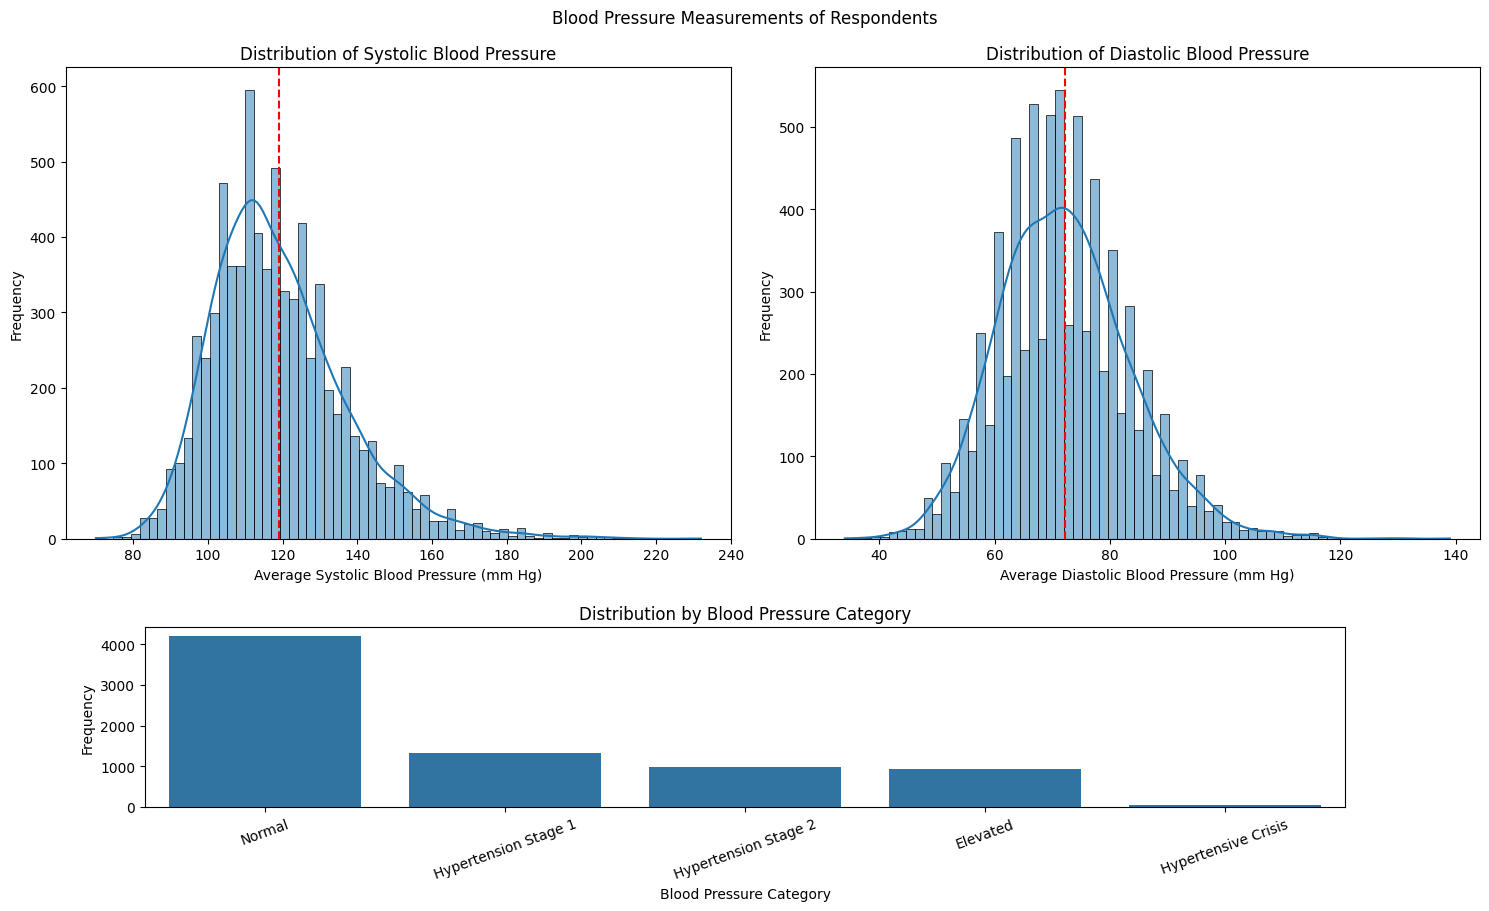

In [13]:
# Show distribution of BP measurements
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Systolic BP
sbp_data = df.dropna(subset='avg_systolic_bp')
sns.histplot(data=sbp_data, x='avg_systolic_bp', kde=True, ax=axs[0])
axs[0].axvline(sbp_data['avg_systolic_bp'].mean(), color='red', linestyle='--', label='Mean')
axs[0].set_xlabel('Average Systolic Blood Pressure (mm Hg)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Systolic Blood Pressure')

# Diastolic BP
dbp_data = df.dropna(subset='avg_diastolic_bp')
sns.histplot(data=dbp_data, x='avg_diastolic_bp', kde=True, ax=axs[1])
axs[1].axvline(dbp_data['avg_diastolic_bp'].mean(), color='red', linestyle='--', label='Mean')
axs[1].set_xlabel('Average Diastolic Blood Pressure (mm Hg)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Diastolic Blood Pressure')

# BP Categories
bp_category_counts = df['bp_category'].value_counts()
ax3 = fig.add_axes([0.1, -0.35, 0.8, 0.3])
sns.barplot(x=bp_category_counts.index, y=bp_category_counts.values, ax=ax3)
ax3.set_xlabel('Blood Pressure Category')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution by Blood Pressure Category')
ax3.set_xticklabels(bp_category_counts.index, rotation=20)


plt.suptitle('Blood Pressure Measurements of Respondents')
plt.tight_layout()
plt.show()

C:\Users\UZOMA\AppData\Local\Temp\ipykernel_11800\3421422166.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=20)


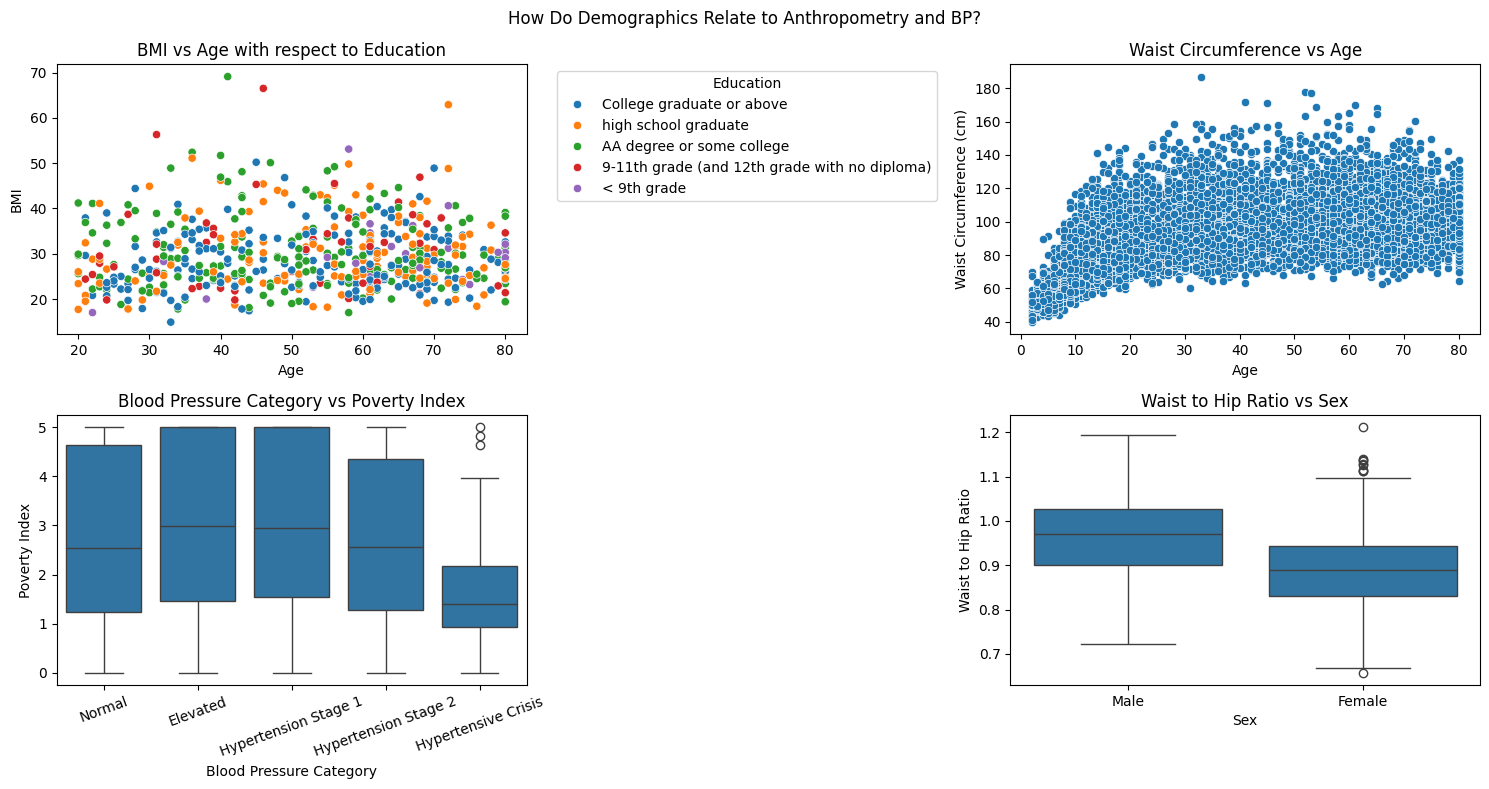

In [14]:
# Show relationship between demographics, anthropometry and BP
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()

# BMI vs Age with respect to educational level
df_age_bmi = df.dropna(subset=['age', 'bmi', 'education_label'])
sample_df = df_age_bmi[['age', 'bmi', 'education_label']].sample(frac=0.1, random_state=1) # randomly sample 10% for better visualization
sns.scatterplot(data=sample_df, x='age', y='bmi', hue='education_label', ax=axs[0])
axs[0].set_xlabel('Age')
axs[0].set_ylabel('BMI')
axs[0].legend(title='Education', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].set_title('BMI vs Age with respect to Education')

# Waist Circumference vs Age
df_age_wc = df.dropna(subset=['age', 'waist_circumference_cm'])
sns.scatterplot(data=df_age_wc, x='age', y='waist_circumference_cm', ax=axs[1])
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Waist Circumference (cm)')
axs[1].set_title('Waist Circumference vs Age')

# Poverty Index vs BP Category  
df_poverty_bp = df.dropna(subset=['poverty_index', 'bp_category'])
sns.boxplot(data=df_poverty_bp, x='bp_category', y='poverty_index', order=bp_order, ax=axs[2])
axs[2].set_xlabel('Blood Pressure Category')
axs[2].set_ylabel('Poverty Index')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=20)
axs[2].set_title('Blood Pressure Category vs Poverty Index')

# Waist to Hip Ratio vs Sex
df_waist_hip = df.dropna(subset=['waist_hip_ratio', 'gender_label'])
sns.boxplot(data=df_waist_hip, x='gender_label', y='waist_hip_ratio', ax=axs[3])
axs[3].set_xlabel('Sex')
axs[3].set_ylabel('Waist to Hip Ratio')
axs[3].set_title('Waist to Hip Ratio vs Sex')


plt.suptitle('How Do Demographics Relate to Anthropometry and BP?')
plt.tight_layout()
plt.show()

## Objective 2: Demographics vs Labs

Not all lab values change for the same reasons. Some change naturally with age or differ between males and females.

### What I looked at
I examined how lab markers vary with age, gender, race, education level, and poverty index.

### How it’s shown
- Heatmap of the demographics vs. lab markers  
- Boxplots and Scatterplots of the significant associations

### Why it matters
These patterns help explain later results and remind us that lab values never exist in isolation.


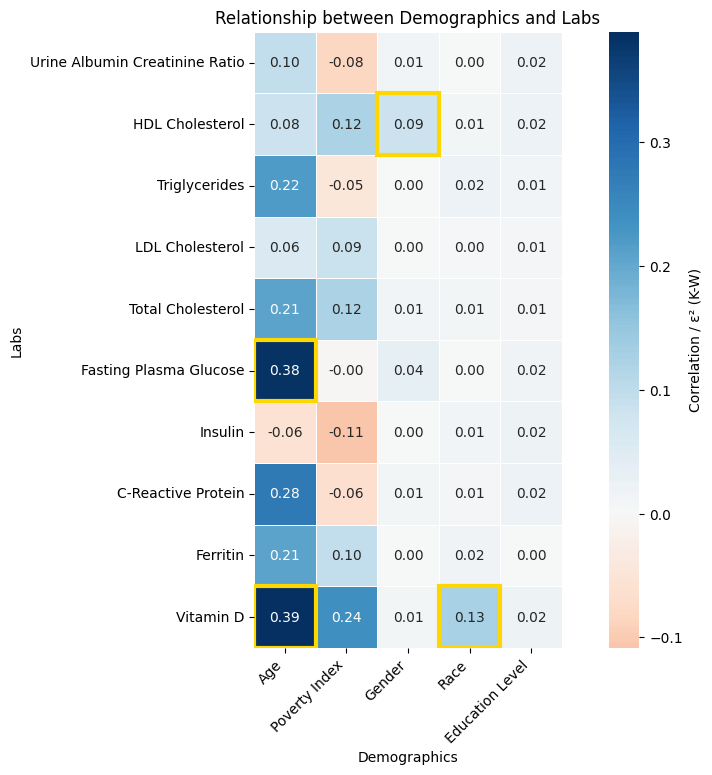

In [15]:
# Create list for storing significant pairs
significant_pairs = []

# Initialize heatmap dataframe
heatmap_df = pd.DataFrame(index=labs.keys(), columns=[*demo_cont.keys()] + [*demo_cat.keys()], dtype=float)

# Continuous demographics: Spearman correlation
for lab in labs.keys():
    for demo in demo_cont.keys():
        corr, p_value = spearmanr(df[lab], df[demo], nan_policy='omit')
        heatmap_df.loc[lab, demo] = corr
        if p_value < 0.05 and abs(corr) >= effect_cutoff_cont:
            significant_pairs.append((lab, demo))

# Categorical demographics: Kruskal-Wallis
for demo in demo_cat.keys():
    categories = df[demo].dropna().unique()
    for lab in labs.keys():
        valid_groups = []
        for cat in categories:
            values = df.loc[df[demo] == cat, lab].dropna()
            if len(values) >= 2 and values.var() > 0:
                valid_groups.append(values)
        if len(valid_groups) < 2:
            heatmap_df.loc[lab, demo] = 0.0
            continue

        H, p_value = kruskal(*valid_groups)
        k = len(valid_groups)
        n = sum(len(g) for g in valid_groups)
        epsilon_sq = (H - k + 1) / (n - k)
        heatmap_df.loc[lab, demo] = epsilon_sq

        if p_value < 0.05 and epsilon_sq >= effect_cutoff_cat:
            significant_pairs.append((lab, demo))

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_df.astype(float),
    cmap='RdBu',
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    center=0,
    square=True,
    cbar_kws={'label': 'Correlation / ε² (K-W)'}
)

# Highlight significant cells
for (lab, demo) in significant_pairs:
    i = heatmap_df.index.get_loc(lab)
    j = heatmap_df.columns.get_loc(demo)
    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='gold', lw=3))

plt.xticks(rotation=45, ha='right', ticks=np.arange(len(heatmap_df.columns)) + 0.5, labels=[*demo_cont.values()] + [*demo_cat.values()])
plt.yticks(ticks=np.arange(len(heatmap_df.index)) + 0.5, labels=labs.values())
plt.xlabel('Demographics')
plt.ylabel('Labs')
plt.title('Relationship between Demographics and Labs')
plt.show()


C:\Users\UZOMA\AppData\Local\Temp\ipykernel_11800\1768550230.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\UZOMA\AppData\Local\Temp\ipykernel_11800\1768550230.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


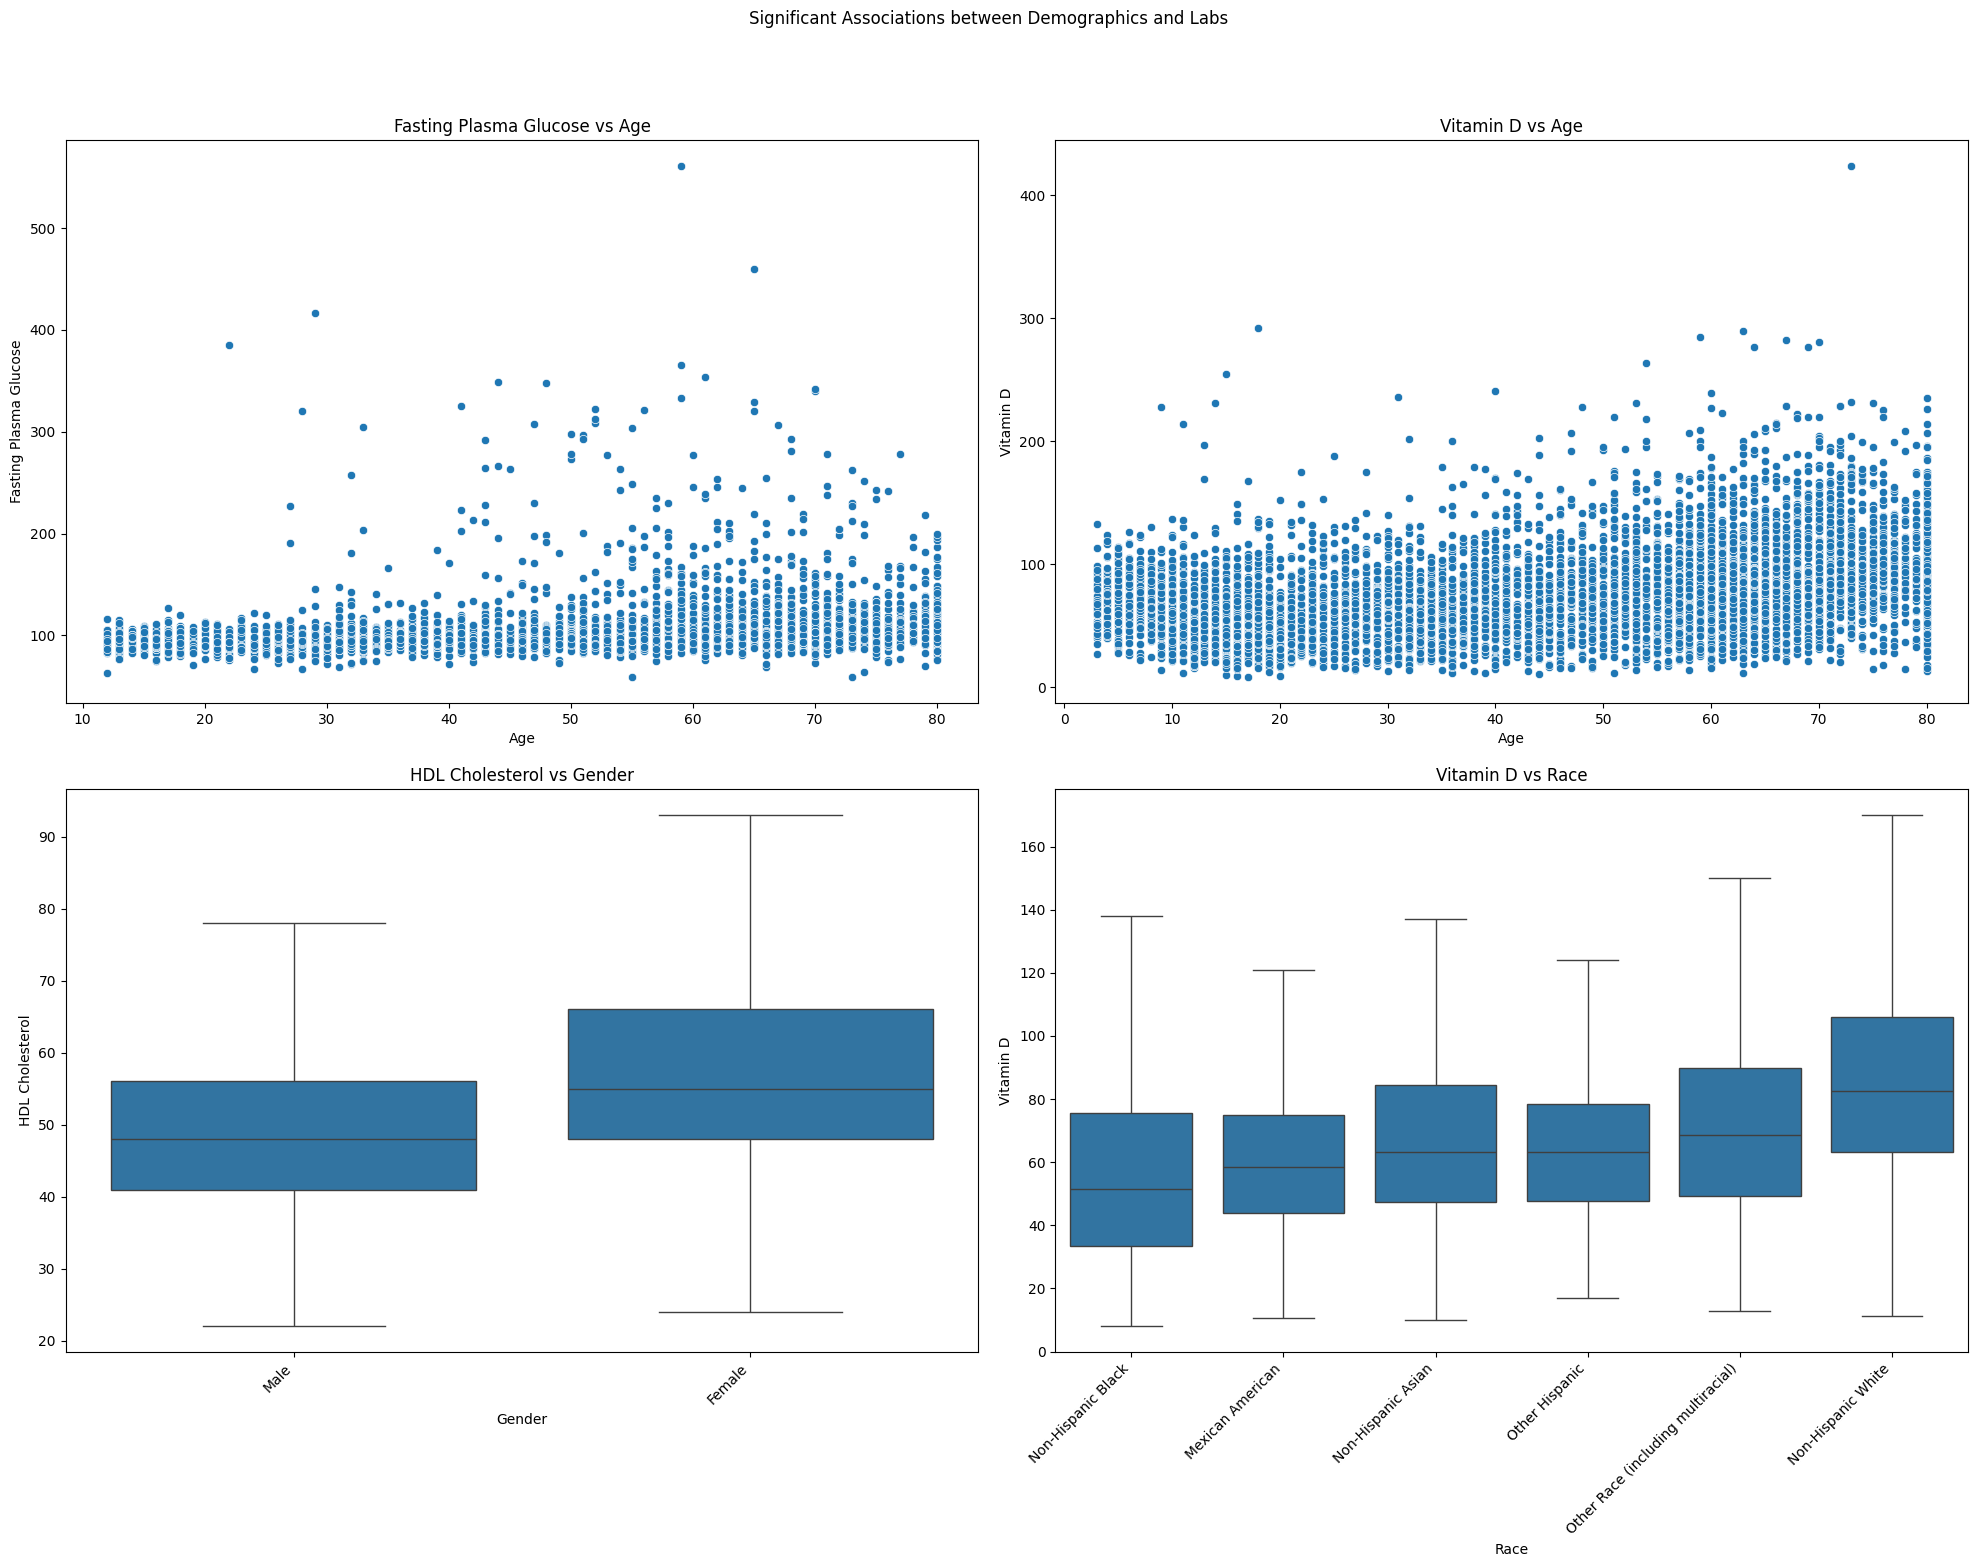

In [16]:
# Visualize significant associations between demographics and labs

# Plot the graphs
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
axs = axs.flatten()

for i, (lab, demo) in enumerate(significant_pairs):
    ax = axs[i]
    
    if demo in demo_cont.keys():
        sns.scatterplot(data=df, x=demo, y=lab, ax=ax)
    elif demo in demo_cat.keys():
        sns.boxplot(data=df, x=demo, y=lab, showfliers=False, order=df.groupby(demo)[lab].median().sort_values().index, ax=ax)
    
    ax.set_xlabel(demo_cont.get(demo, demo_cat.get(demo, demo)))
    ax.set_ylabel(labs.get(lab, lab))
    ax.set_title(f'{labs.get(lab, lab)} vs {demo_cont.get(demo, demo_cat.get(demo, demo))}')

    # Conditional xticks rotation for categorical variables
    if demo in demo_cat.keys():
        max_label_len = max([len(str(label)) for label in df[demo].unique()])
        if max_label_len > 5:  # threshold for “long text”
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Remove empty axes
for j in range(len(significant_pairs), len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Significant Associations between Demographics and Labs')
plt.rcParams.update({'font.size': 14})
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Objective 3: Supplements vs Labs

Many people take supplements hoping to improve their health.  Do supplement habits reflect what we see in lab results?

### What I looked at
I looked at the supplement distribution and explored whether supplement intake and burden relates to lab markers.

### How it’s shown
- Bar charts showing distribution of individual and total supplements taken
- A correlation heatmap to summarize overall patterns
- A violin plot highlighting significant associations adjusted for significant demographic variables

### Why it matters
This helps separate perception from physiology and shows whether supplement use aligns with measurable changes.

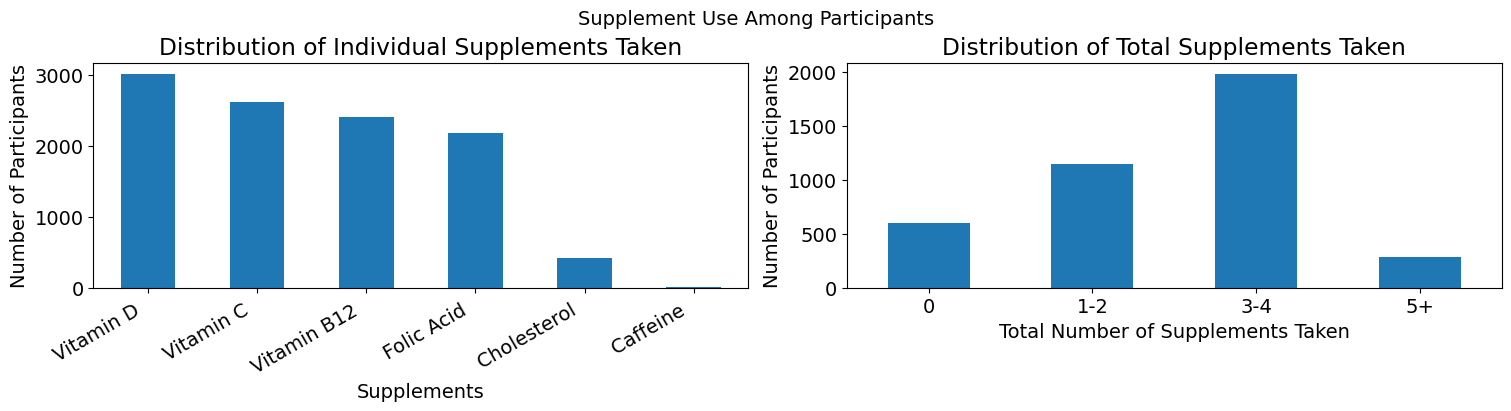

In [17]:
# Compute counts
supplement_counts = df[supplement_cols].sum().sort_values(ascending=False)
burden_counts = df['supplement_burden_score_group'].value_counts().sort_index()

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(15, 4), constrained_layout=True)

# Plot 1: Individual supplements
supplement_counts.plot(kind='bar', ax=axs[0])
axs[0].set_xticklabels(
    [label for _, label in sorted(zip(supplement_cols, supplement_labels),
                                  key=lambda x: supplement_counts[x[0]],
                                  reverse=True)],
    rotation=30,
    ha='right'
)
axs[0].set_xlabel('Supplements')
axs[0].set_ylabel('Number of Participants')
axs[0].set_title('Distribution of Individual Supplements Taken')

# Plot 2: Total supplements taken
burden_counts.plot(kind='bar', ax=axs[1])
axs[1].set_xticks(ticks=axs[1].get_xticks(), labels=axs[1].get_xticklabels(), rotation=0)
axs[1].set_xlabel('Total Number of Supplements Taken')
axs[1].set_ylabel('Number of Participants')
axs[1].set_title('Distribution of Total Supplements Taken')

# Super title
fig.suptitle('Supplement Use Among Participants', fontsize=14)

plt.show()


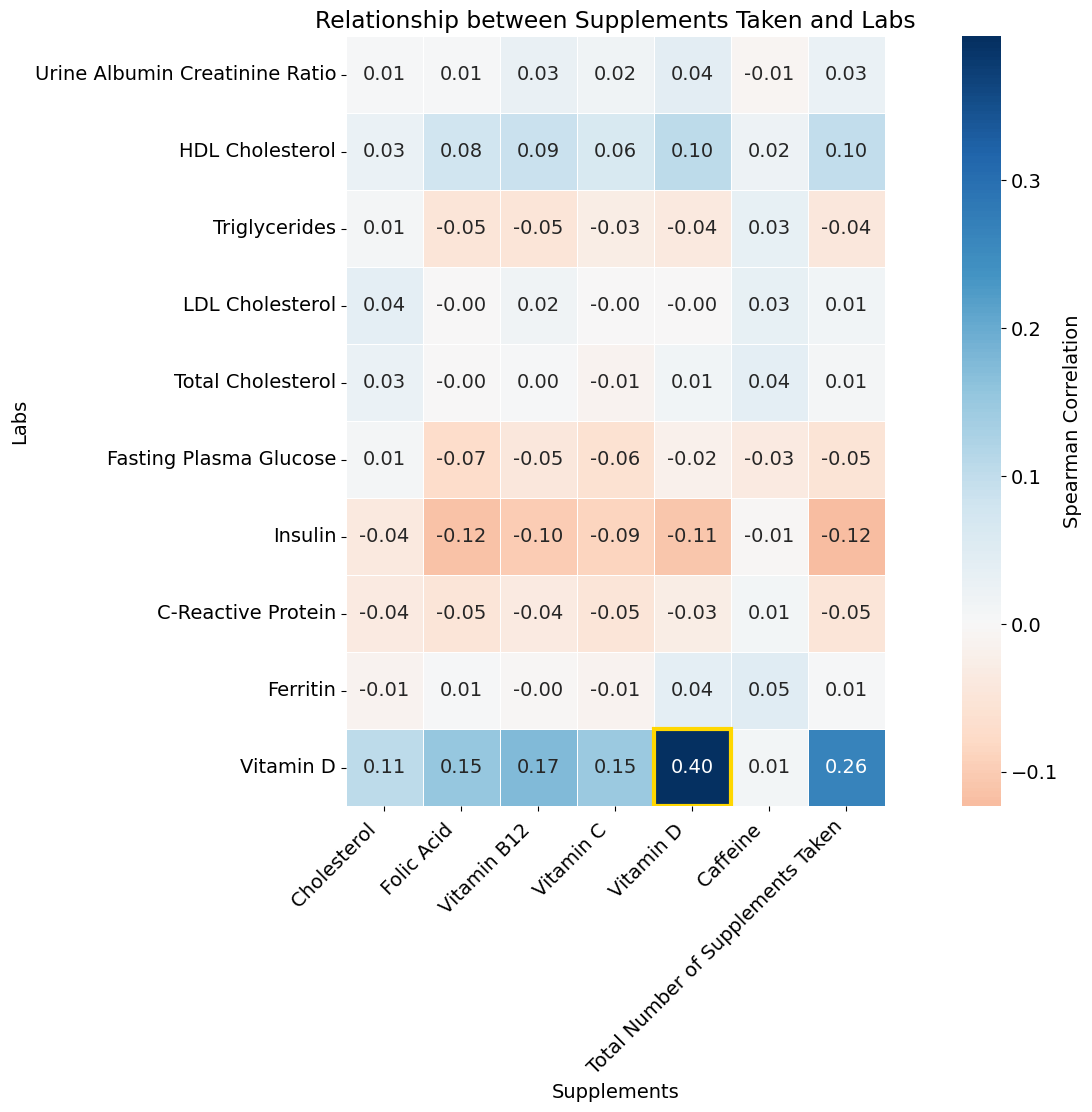

In [18]:
# Supplements used
supplements = [col for col in df.columns if col.startswith('takes')] + ['supplement_burden_score']
supplements_labels = [col.replace('takes_', '').replace('_', ' ').replace('supplement', '').title() for col in supplements][0:-1] + ['Total Number of Supplements Taken']

# Initialize
heatmap_df = pd.DataFrame(index=labs, columns=supplements, dtype=float)
significant_pairs = []

# Spearman correlations
for lab in labs:
    for supplement in supplements:
        corr, p_value = spearmanr(df[lab], df[supplement], nan_policy='omit')
        heatmap_df.loc[lab, supplement] = corr

        if p_value < 0.05 and abs(corr) >= effect_cutoff_cont:
            significant_pairs.append((lab, supplement))

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(
    heatmap_df.astype(float),
    cmap='RdBu',
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    center=0,
    square=True,
    cbar_kws={'label': 'Spearman Correlation'}
)

# Highlight significant cells
for lab, supplement in significant_pairs:
    i = heatmap_df.index.get_loc(lab)
    j = heatmap_df.columns.get_loc(supplement)
    plt.gca().add_patch(
        plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='gold', lw=3)
    )

# Labels
plt.xticks(
    ticks=np.arange(len(supplements)) + 0.5,
    labels=supplements_labels,
    rotation=45,
    ha='right'
)
plt.yticks(
    ticks=np.arange(len(labs)) + 0.5,
    labels=labs.values()
)
plt.xlabel('Supplements')
plt.ylabel('Labs')
plt.title('Relationship between Supplements Taken and Labs')
plt.show()

C:\Users\UZOMA\AppData\Local\Temp\ipykernel_11800\1710949578.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vit_d_subset['adjusted_vitamin_d'] = model.predict(vit_d_subset)


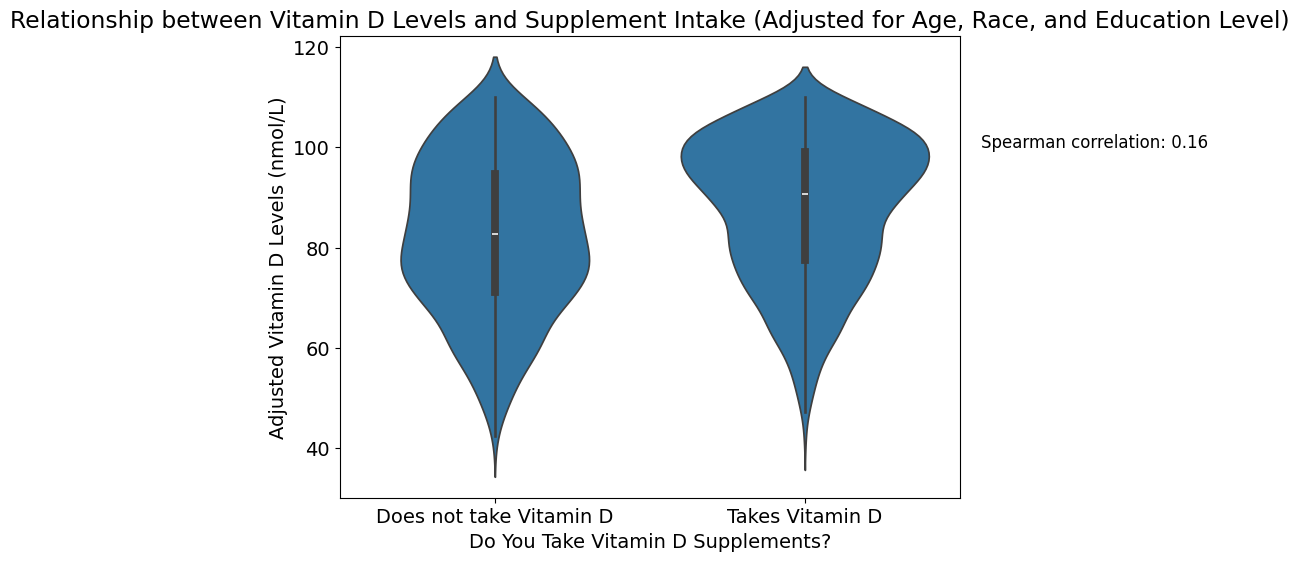

In [19]:
# Visualize relationship between Vitamin D levels and intake of Vitamin D supplements while adjusting for age, race, and education level

plt.figure(figsize=(8, 6))

# Adjust Vitamin D levels for age, race, and education level
vit_d_subset = df.dropna(subset=['vitamin_d2_d3_nmol_per_L', 'age', 'race', 'education'])
model = smf.ols(formula='vitamin_d2_d3_nmol_per_L ~ age + C(race) + C(education)', data=vit_d_subset).fit()
vit_d_subset['adjusted_vitamin_d'] = model.predict(vit_d_subset)

# Plot violin plot of adjusted Vitamin D levels vs supplement intake
sns.violinplot(data=vit_d_subset, x='takes_vitamin_d_supplement', y='adjusted_vitamin_d')
plt.xticks(ticks=[0, 1], labels=['Does not take Vitamin D', 'Takes Vitamin D'])
plt.xlabel('Do You Take Vitamin D Supplements?')
plt.ylabel('Adjusted Vitamin D Levels (nmol/L)')
plt.title('Relationship between Vitamin D Levels and Supplement Intake (Adjusted for Age, Race, and Education Level)')

# Show spearman correlation for the relationship between adjusted vitamin D levels and supplement intake
plt.text(x=2.3, y=100, 
         s=f'Spearman correlation: {spearmanr(vit_d_subset["adjusted_vitamin_d"], vit_d_subset["takes_vitamin_d_supplement"], nan_policy='omit')[0]:.2f}',
         ha='right', fontsize=12)
plt.show()

## Objective 4: Anthropometry vs Labs 
### Does Central Obesity Tell a Better Story than BMI?

This is the heart of the project.

BMI treats weight as a single number, but waist size and waist-to-hip ratio capture where fat is stored. That difference may matter more than total weight.

### What I looked at
I compared BMI, waist circumference, and waist-to-hip ratio against the lab markers.

### How it’s shown
- A correlation heatmap comparing all three measures  
- A bar chart showing mean absolute correlation

### Why it matters
This section asks a simple but important question:  
Does fat around the waist say more about health than the number on the scale?

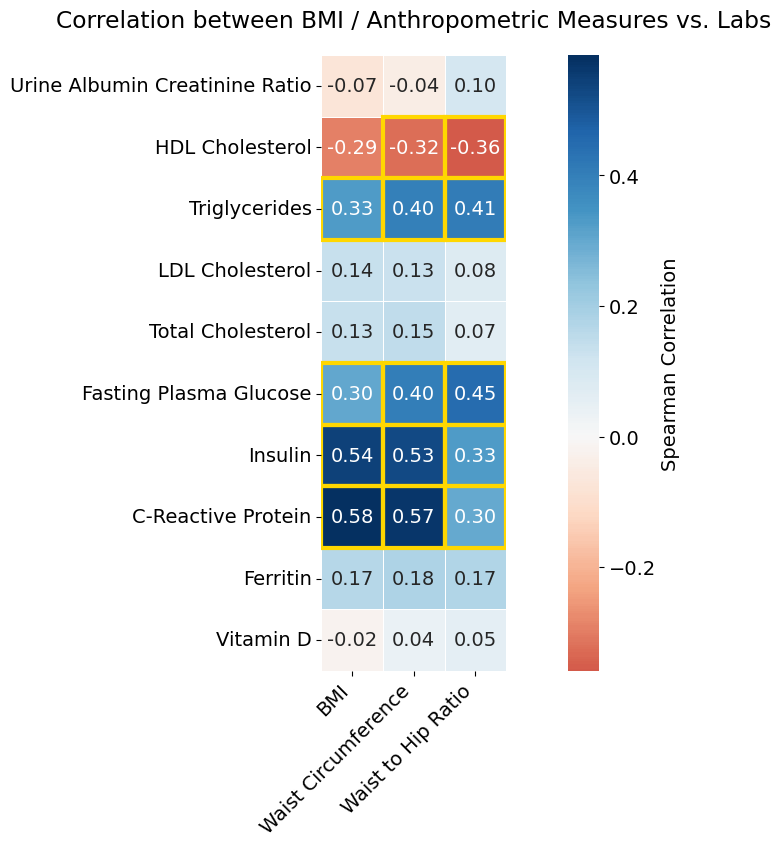

In [20]:
# Anthropometric measures and correlations
anthro_cols = ['bmi', 'waist_circumference_cm', 'waist_hip_ratio']
anthro_labels = ['BMI', 'Waist Circumference', 'Waist to Hip Ratio']

# Initialize
heatmap_df = pd.DataFrame(index=labs, columns=anthro_labels, dtype=float)
mask = pd.DataFrame(False, index=labs, columns=anthro_labels)

# Compute Spearman Correlations
for lab in labs:
    for col, label in zip(anthro_cols, anthro_labels):
        corr, p_value = spearmanr(df[col], df[lab], nan_policy='omit')
        heatmap_df.loc[lab, label] = corr
        mask.loc[lab, label] = round(abs(corr), 2) >= effect_cutoff_cont and p_value < 0.05  # highlight correlations

# Plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_df.astype(float),
    cmap='RdBu',
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    center=0,
    square=True,
    cbar_kws={'label': 'Spearman Correlation'}
)

# Highlight significant cells
for i in range(len(heatmap_df.index)):
    for j in range(len(heatmap_df.columns)):
        if mask.iloc[i, j]:
            plt.gca().add_patch(
                plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='gold', lw=3)
            )

# Label chart
plt.yticks(ticks=np.arange(len(labs))+0.5, labels=labs.values())
plt.xticks(ticks=np.arange(len(heatmap_df.columns))+0.5, rotation=45, ha='right')
plt.title('Correlation between BMI / Anthropometric Measures vs. Labs', pad=20)
plt.show()


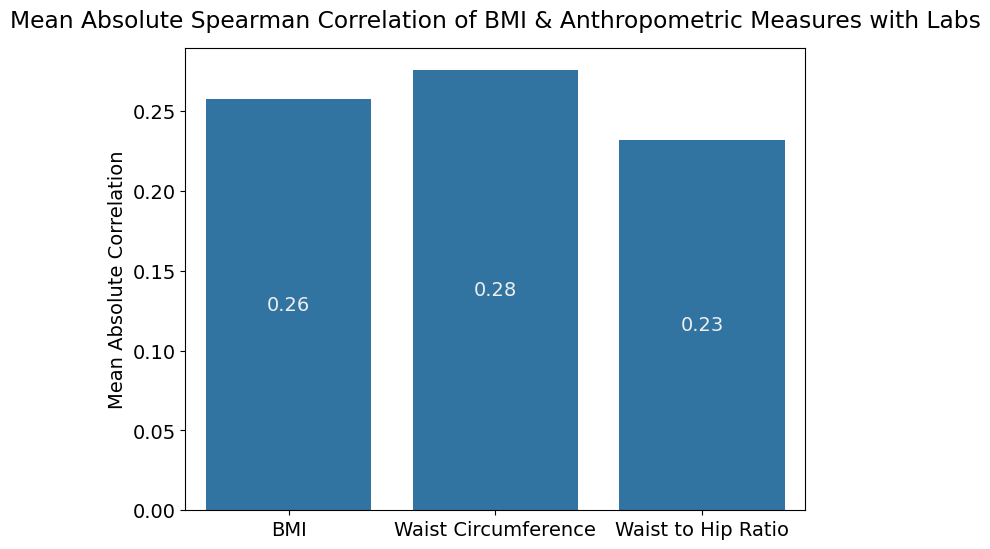

In [21]:
# Get mean absolute Spearman correlation
mean_abs_corr_data = heatmap_df.abs().mean(axis=0).reset_index().rename(columns={'index': 'Predictor', 0: 'Mean Absolute Correlation'})

# Visualize with a barplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=mean_abs_corr_data, x='Predictor', y='Mean Absolute Correlation', ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='#eeeeee')

plt.xlabel('')
plt.title('Mean Absolute Spearman Correlation of BMI & Anthropometric Measures with Labs', pad=15)
plt.show()

## Objective 5: Blood Pressure vs Labs

Blood pressure reflects cardiovascular strain, but it may also mirror deeper metabolic or inflammatory changes.

### What I looked at
I compared lab markers across different blood pressure categories.

### How it’s shown
- A correlation heatmap showing relationship between Systolic BP, Diastolic BP, BP Class and Labs
- A boxplot and pointplot combo highlighting significant associations

### Why it matters
This shows whether lab abnormalities tend to cluster with elevated blood pressure.

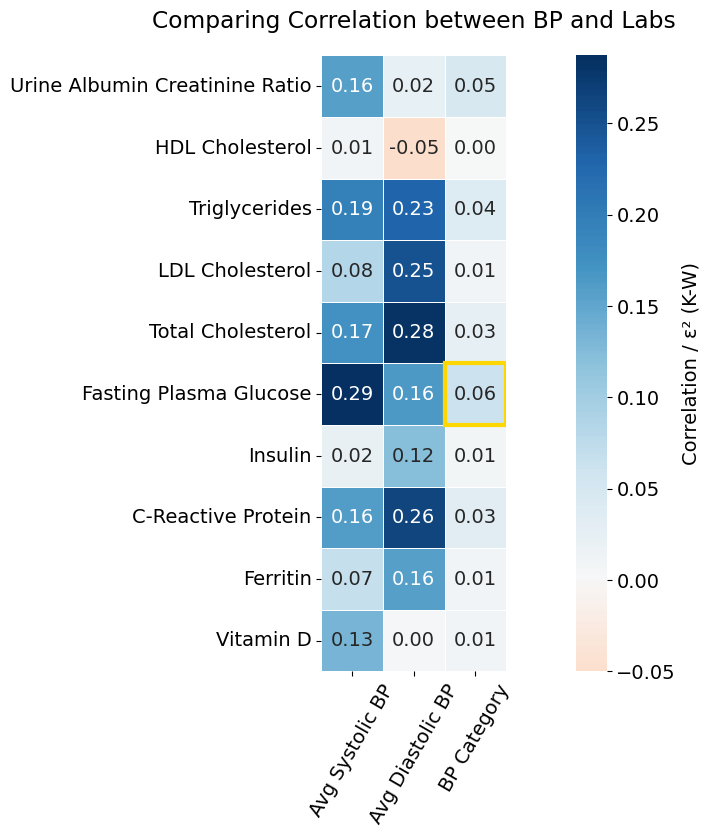

In [22]:
# Get BP Correlation with Labs

# Parameters
bp_cols = ['avg_systolic_bp', 'avg_diastolic_bp']

# Initialize
heatmap_df = pd.DataFrame(index=labs, columns=bp_cols + ['bp_category'])
significant_pairs = []

# Spearman Correlation
for bp in bp_cols:
    for lab in labs:
        corr, p_value = spearmanr(df[lab], df[bp], nan_policy="omit")
        heatmap_df.loc[lab, bp] = corr
        if p_value < 0.05 and abs(corr) >= effect_cutoff_cont:
            significant_pairs.append((lab, bp))

# Kruskal-Wallis
for lab in labs:
    groups = [
        df.loc[df['bp_category'] == cat, lab].dropna()
        for cat in df['bp_category'].dropna().unique()
    ]
    groups = [g for g in groups if len(g) >= 2 and g.var() > 0]

    if len(groups) >= 2:
        H, p_value = kruskal(*groups)
        k = len(groups)
        n = sum(len(g) for g in groups)
        epsilon_sq = (H - k + 1) / (n - k)
        heatmap_df.loc[lab, 'bp_category'] = epsilon_sq
        if p_value < 0.05 and epsilon_sq >= effect_cutoff_cat:
            significant_pairs.append((lab, 'bp_category'))
    else:
        heatmap_df.loc[lab, 'bp_category'] = 0.0

# Plot Heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(
    data=heatmap_df.astype(float),
    cmap='RdBu',
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    center=0,
    square=True,
    cbar_kws={'label': 'Correlation / ε² (K-W)'}
)

# Highlight significant cells
for (lab, col) in significant_pairs:
    i = heatmap_df.index.get_loc(lab)
    j = heatmap_df.columns.get_loc(col)
    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='gold', lw=3))

plt.xticks(ticks=np.arange(len(heatmap_df.columns))+0.5, labels=['Avg Systolic BP', 'Avg Diastolic BP', 'BP Category'], rotation=60)
plt.yticks(ticks=np.arange(len(labs))+0.5, labels=labs.values())
plt.title('Comparing Correlation between BP and Labs', pad=20)
plt.show()


C:\Users\UZOMA\AppData\Local\Temp\ipykernel_11800\208220177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='bp_category', y='fasting_glucose_mg_per_dL', order=bp_order, showfliers=False, palette='pastel')


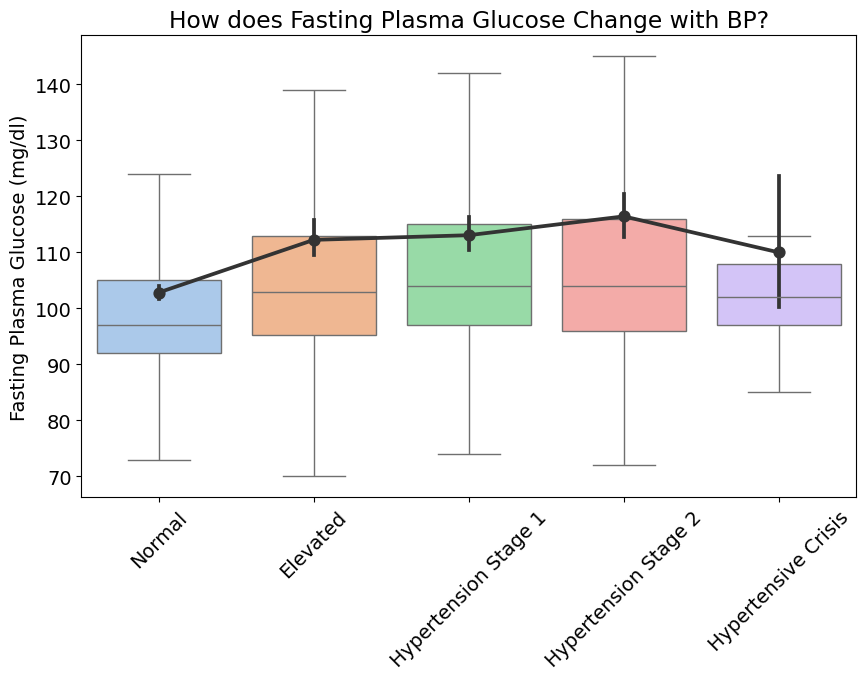

In [23]:
# Visualize the change in FPG with BP 
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='bp_category', y='fasting_glucose_mg_per_dL', order=bp_order, showfliers=False, palette='pastel')
sns.pointplot(data=df, x='bp_category', y='fasting_glucose_mg_per_dL', order=bp_order, color='#333333')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Fasting Plasma Glucose (mg/dl)')
plt.title('How does Fasting Plasma Glucose Change with BP?')
plt.show()


## Objective 6: Labs vs Labs

Lab values rarely act alone. Inflammation, metabolism, and lipid markers often move together.

### What I looked at
I examined how all lab markers correlate with one another.

### How it’s shown
- Correlation heatmap across all lab markers  
- Regression plots for key relationships

### Why it matters
Understanding these connections helps tie together patterns seen throughout the analysis.

Text(0.5, 1.0, 'Correlation Between Labs')

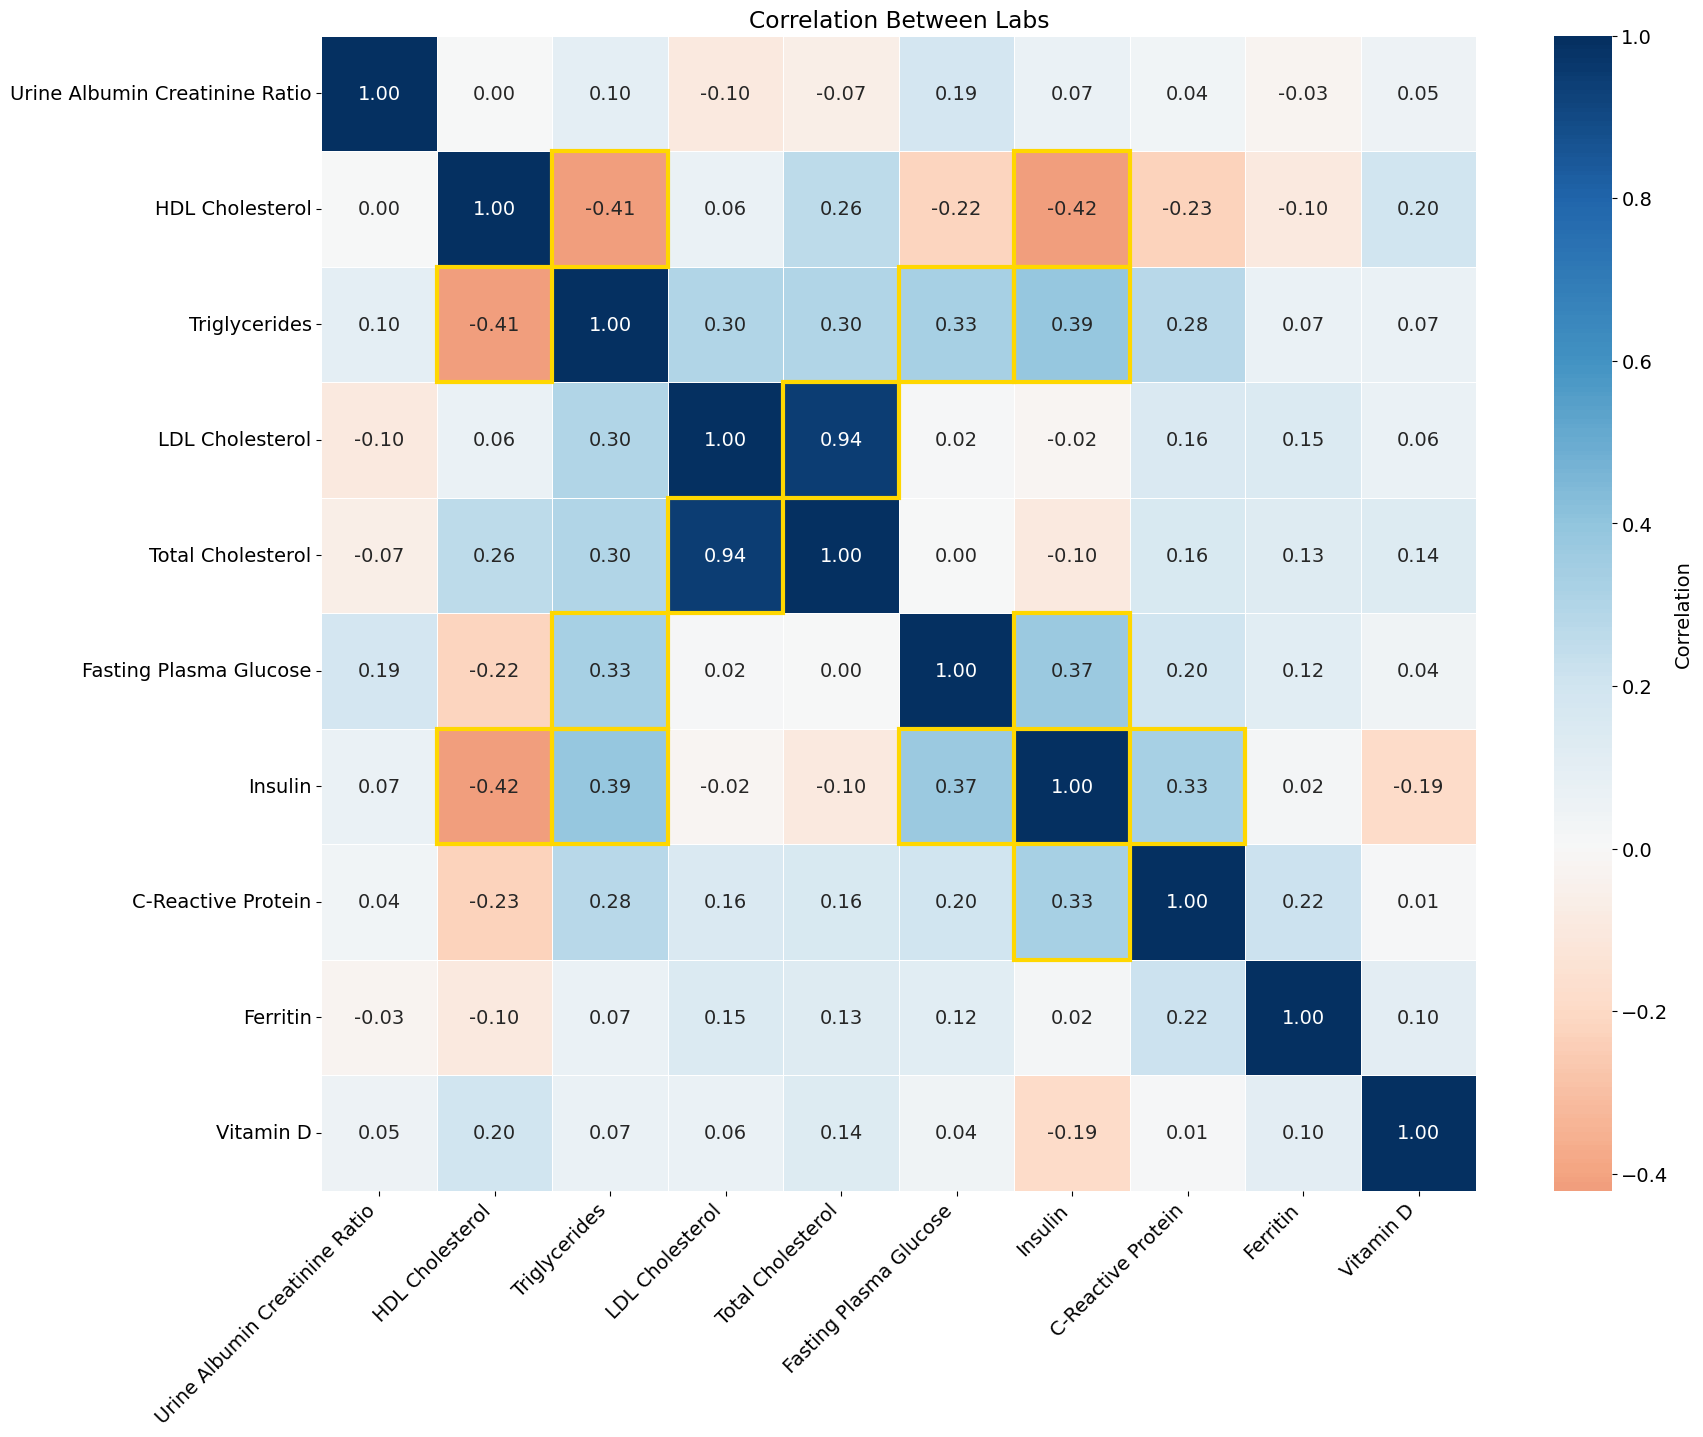

In [24]:
# Initialize
heatmap_df = pd.DataFrame(index=labs)
significant_pairs = []

# Add correlation values to the dataframe
for lab_i in labs:
    for lab_c in labs:
        corr, p_value = spearmanr(df[lab_i], df[lab_c], nan_policy='omit')
        heatmap_df.loc[lab_i, lab_c] = corr
        if (p_value < 0.05) and (abs(round(corr, 2)) > 0.3) and (lab_i != lab_c):
            significant_pairs.append((lab_i, lab_c))

# Plot heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(
    data=heatmap_df, 
    cmap='RdBu', 
    square=True, 
    center=0, 
    cbar=True, 
    cbar_kws={'label': 'Correlation'}, 
    linewidths=0.5, 
    annot=True, 
    fmt='.2f')

# Highlight significant cells
for (lab, col) in significant_pairs:
    i = heatmap_df.index.get_loc(lab)
    j = heatmap_df.columns.get_loc(col)
    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='gold', lw=3))

# Label chart
plt.xticks(ticks=np.arange(len(heatmap_df.columns))+0.5, labels=labs.values(), rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(heatmap_df.index))+0.5, labels=labs.values())
plt.title('Correlation Between Labs')

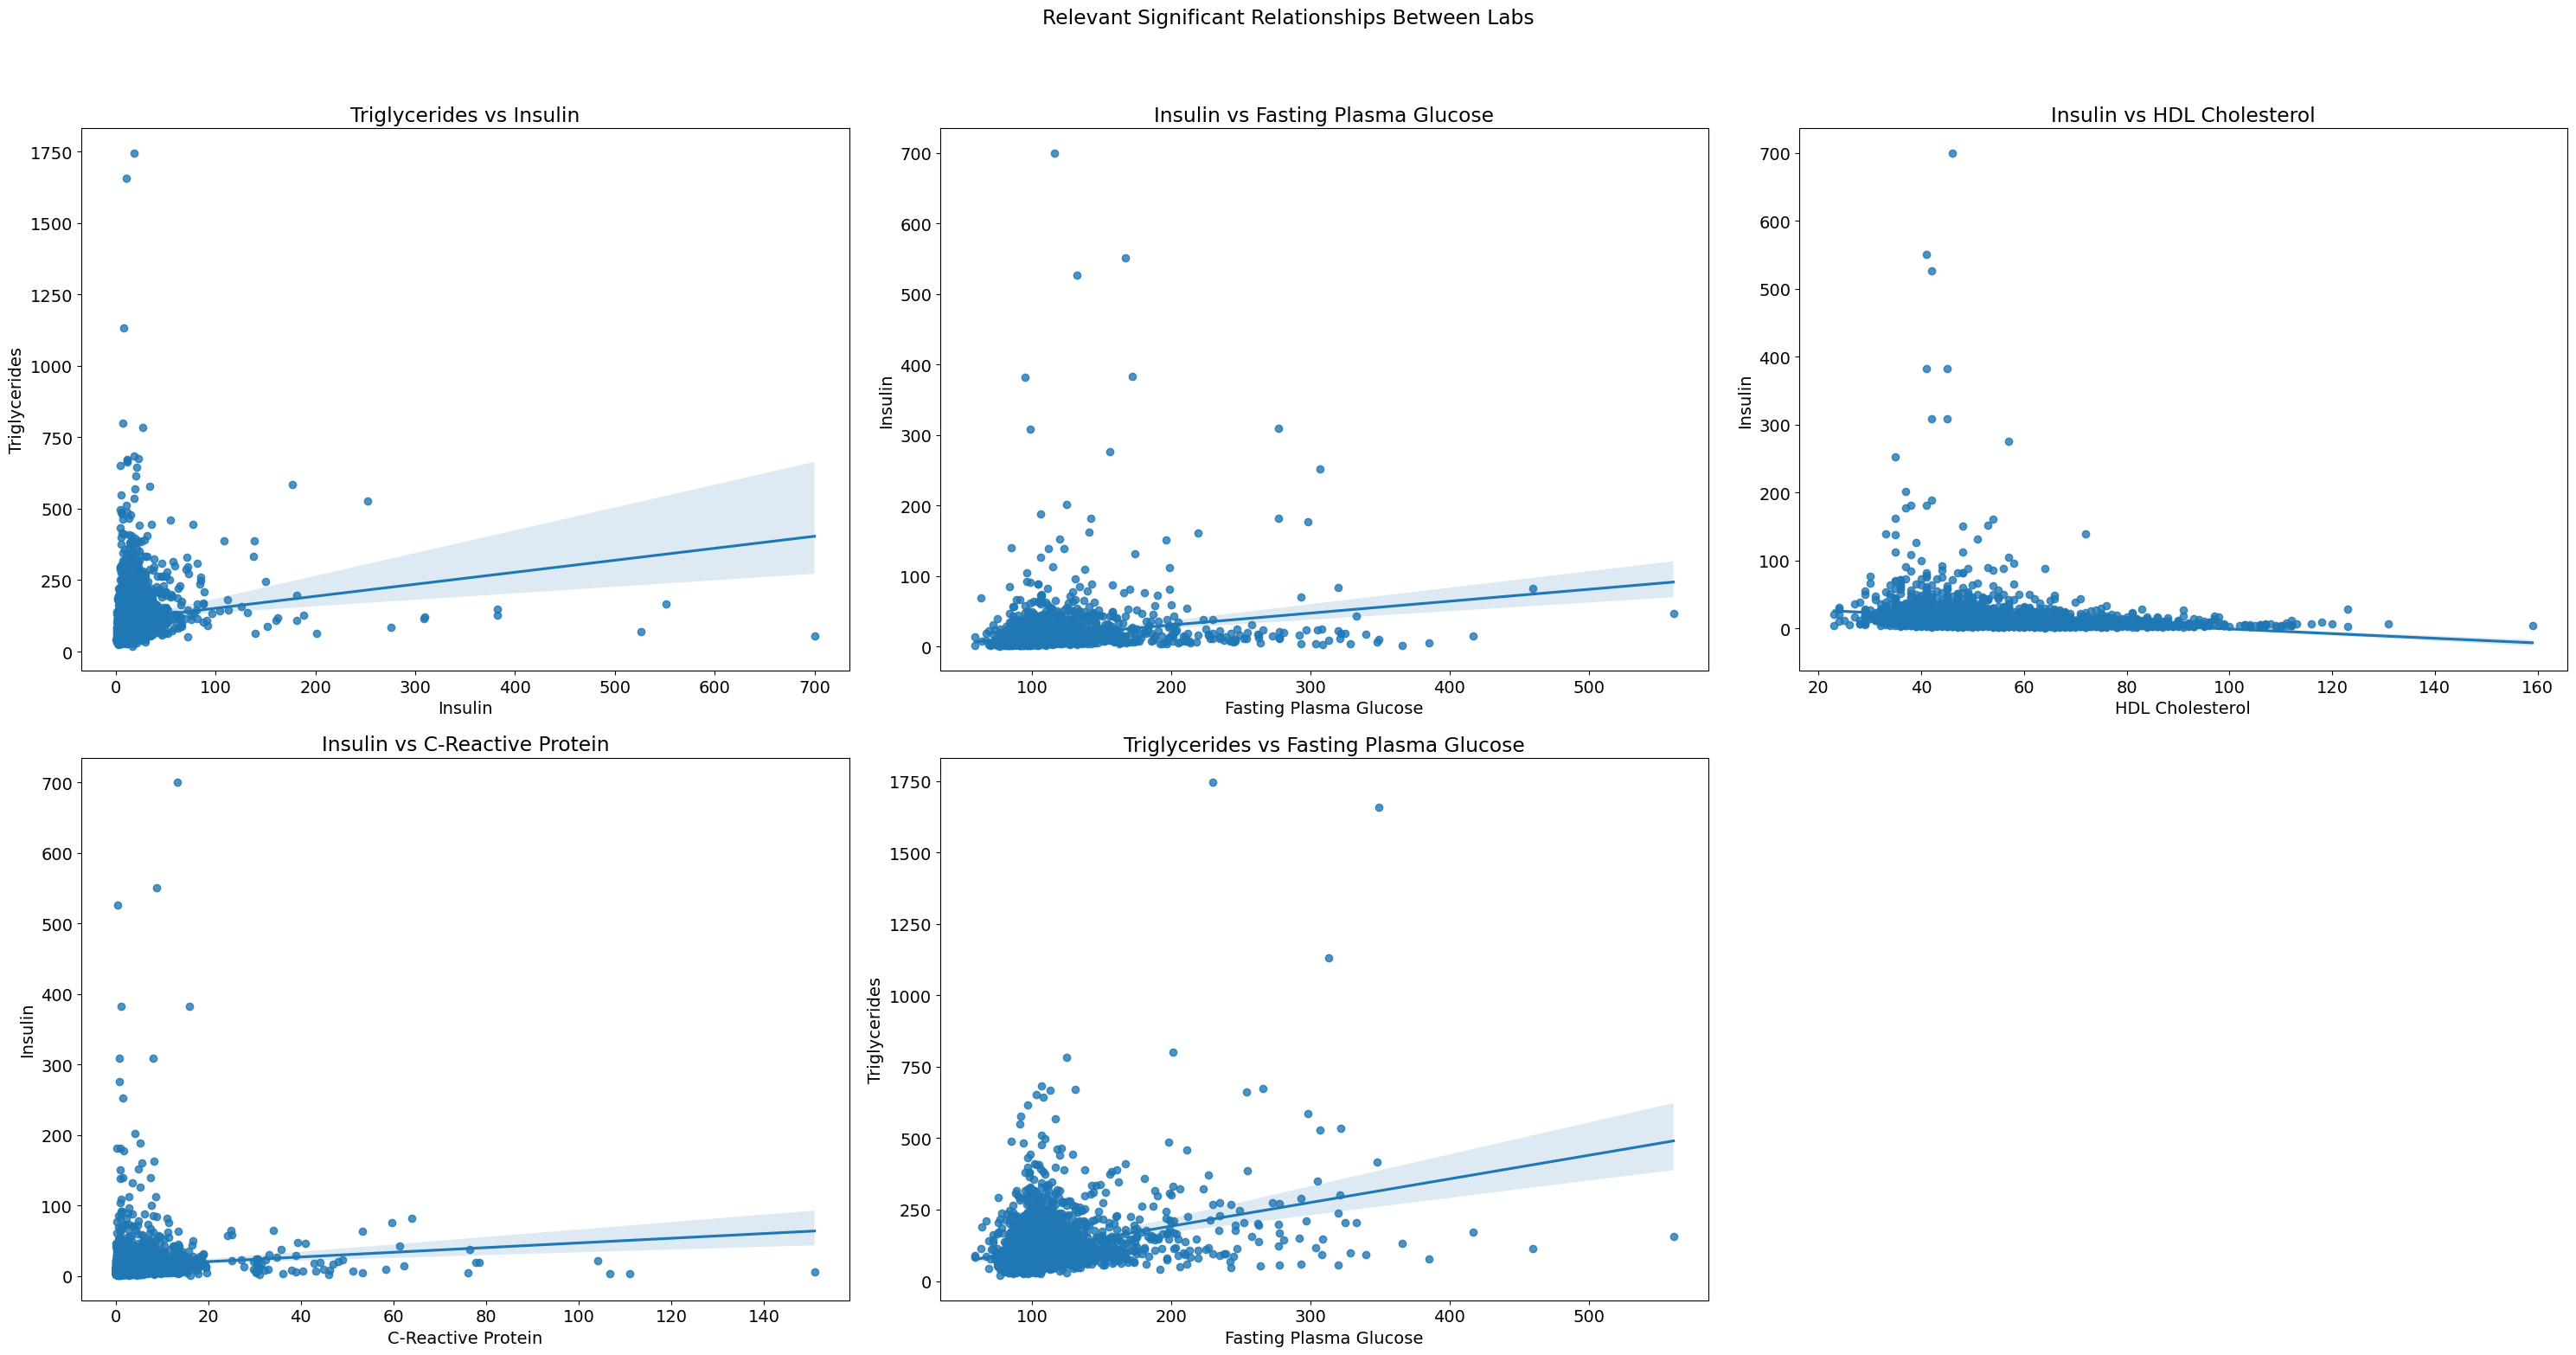

In [25]:
# Visualize relevant significant relationships with line charts

# Select relevant relationships
rel = [
    ('insulin_uU_per_mL', 'triglycerides_mg_per_dL'),
    ('fasting_glucose_mg_per_dL', 'insulin_uU_per_mL'),
    ('hdl_cholesterol_mg_per_dL', 'insulin_uU_per_mL'),
    ('hs_crp_mg_per_L', 'insulin_uU_per_mL'),
    ('fasting_glucose_mg_per_dL', 'triglycerides_mg_per_dL')
 ]

# Plot the graphs
n = len(rel)
cols = 3
rows = (n + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(cols*10, rows*8))
axs = axs.flatten()

for i, (lab1, lab2) in enumerate(rel):
    ax = axs[i]
    sns.regplot(data=df, x=lab1, y=lab2, ax=ax)
    ax.set_xlabel(labs.get(lab1, lab1))
    ax.set_ylabel(labs.get(lab2, lab2))
    ax.set_title(f'{labs.get(lab2, lab2)} vs {labs.get(lab1, lab1)}')

# Remove empty axes
for j in range(len(rel), len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Relevant Significant Relationships Between Labs')
plt.rcParams.update({'font.size': 14})
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Conclusion
- Insulin correlates positively with triglycerides, fasting glucose, and CRP, and negatively with HDL. Could these metabolic and inflammatory links help identify early insulin resistance before traditional screening?

- Waist circumference predicts lab markers better than BMI or WHR, showing stronger ties to CRP, insulin, fasting glucose, triglycerides, and HDL. Should we start prioritizing waist measurements over BMI when estimating metabolic risk?

- Demographics subtly shape lab patterns: females had higher HDL, older age aligned with higher fasting glucose and vitamin D, and Non-Hispanic Blacks had the lowest vitamin D. How much do these hidden population effects alter how we interpret lab results in real-world settings?

- Vitamin D supplementation correlates with serum levels, but this effect drops after adjusting for age, race, and education. Could this mean supplements alone aren’t enough without considering the individual context?

- Blood pressure categories rise with fasting glucose except in hypertensive crisis, revealing a non-linear trend. Could BP levels serve as an early signal for glucose dysregulation if we pay attention to these subtle shifts?

These findings show that lab markers are not isolated numbers but are part of a complex network that might reveal risks before disease becomes visible. 
The real question is: **are we ready to listen to these subtle signals, or do we still rely only on what’s obvious?**